In [1]:
import torch
import numpy as np
import pandas as pd

In [2]:
msa = pd.read_csv('SH3_Full_Dataset_8_9_22.csv')
msa['Type'].unique()
naturals_msa = msa[msa['Type']=='Naturals']
seqs = np.asarray([list(seq) for seq in naturals_msa['Sequences']])
norm_re = np.asarray([re for re in naturals_msa['Norm_RE']])

In [3]:
default_aa_keys='-GALMFWKQESPVICYHRNDT'
def fasta_to_df(fasta_file, aa_keys = default_aa_keys):
    """
    creates one hot encoding of a fasta file using biopython's alignio.read process. 
    fasta_file : filepath leading to msa file in fasta format at hand
    """
    column_names = []
    column_names.extend(aa_keys)
    msa=AlignIO.read(fasta_file, "fasta")
    num_columns = len(msa[0].seq)
    column_names = column_names*num_columns
    column_names.append('sequence')
    column_names.append('id')
    init = np.zeros((len(msa), len(column_names)))
    df = pd.DataFrame(init, columns = column_names)
    df.sequence = df.sequence.astype(str)
    df.id=df.id.astype(str)
    
    for row_num, alignment in tqdm(enumerate(msa)):
        sequence = str(alignment.seq)
        for index, char in enumerate(sequence):
            place = aa_keys.find(char)
            df.iloc[row_num, index*len(aa_keys) + place] = 1
        
        df.iloc[row_num,-2]=str(alignment.seq)
        df.iloc[row_num,-1]=str(alignment.id)
    
    return df

In [4]:
def create_frequency_matrix(df, aa_keys = default_aa_keys):
    """takes one hot encoded msa and returns the frequency of each amino acid at each site
    df : pandas dataframe whose columns are the one hot encoding of an msa
    """
    num_columns=len(df['sequence'][0])
    
    frequency_matrix = np.zeros( (len(aa_keys) , num_columns) )
    print('calcing sum')
    freq=df.sum()
    print('sum calced')
    
    num_entries=len(df)
    len_aa_keys = len(aa_keys)
    
    for i in tqdm(range(len(aa_keys))):
        for j in range(num_columns):
            frequency_matrix[i, j] = freq[ i + len_aa_keys * j] / num_entries
    
    return frequency_matrix

In [5]:
from Bio import AlignIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
vae_alignment = []
phenotypes = []

vae_data = msa[msa['Type']=='VAE'].reset_index()

for r in range(len(vae_data)):
    alignment = vae_data.loc[r]
    if len(alignment['Sequences'])==62:
        record = SeqRecord(seq = Seq(alignment['Sequences']), id = alignment['Header'])
    
    vae_alignment.append(record)
    phenotypes.append(alignment['Norm_RE'])

vae_alignment = AlignIO.MultipleSeqAlignment(vae_alignment)

AlignIO.write(vae_alignment, 'vae_alignment.fasta', 'fasta')

vae_df = fasta_to_df('vae_alignment.fasta')

freq_matrix = create_frequency_matrix(vae_df)

trim_positions = []

for i in range(freq_matrix.shape[1]):
    if 1 in freq_matrix[:,i]:
        trim_positions.append(i)

print(trim_positions)


vae_alignment_trimmed = []


for alignment in vae_alignment:
    new_seq = ''
    for i in range(62):
        if i not in trim_positions:
            new_seq+=alignment.seq[i]
    re_alignment = SeqRecord(seq=Seq(new_seq), id = alignment.id)
    vae_alignment_trimmed.append(re_alignment)

vae_alignment_trimmed = AlignIO.MultipleSeqAlignment(vae_alignment_trimmed)

AlignIO.write(vae_alignment_trimmed, 'vae_alignment_trimmed.fasta', 'fasta')

test_seqs = np.asarray([list(str(alignment.seq)) for alignment in vae_alignment_trimmed])

phenotypes = np.asarray(phenotypes)

11608it [02:01, 95.47it/s] 


calcing sum
sum calced


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 7722.96it/s]


[16, 17, 44]


In [6]:
AMINO_ACIDS = "ARNDCQEGHILKMFPSTWYV-"
IDX_TO_AA = list(AMINO_ACIDS)
AA_TO_IDX = {aa: i for i, aa in enumerate(IDX_TO_AA)}

In [7]:
from NeuralProcessClasses import *
from architecture_classes import *
from utils import *

In [59]:
mlp_encoder = [128,128,128,128,128]
mlp_decoder = [128,128,128,128,21]

encoder = MLP(22, mlp_encoder)
decoder = MLP(mlp_encoder[-1]+1, mlp_decoder)

cnp = ConditionalNeuralProcess(encoder, decoder)

In [60]:
cnp.encoder

MLP(
  (mlp): Sequential(
    (input_layer): Linear(in_features=22, out_features=128, bias=True)
    (relu): ReLU()
    (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_3): ReLU()
    (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
    (relu_4): ReLU()
    (hidden_layer_4): Linear(in_features=128, out_features=128, bias=True)
    (relu_5): ReLU()
  )
)

In [61]:
cnp.decoder

MLP(
  (mlp): Sequential(
    (input_layer): Linear(in_features=129, out_features=128, bias=True)
    (relu): ReLU()
    (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_3): ReLU()
    (hidden_layer_3): Linear(in_features=128, out_features=128, bias=True)
    (relu_4): ReLU()
    (hidden_layer_4): Linear(in_features=128, out_features=21, bias=True)
    (relu_5): ReLU()
  )
)

In [62]:
def adjust_learning_rate(optimizer, step_num, warmup_step=4000):
    lr = 0.001 * warmup_step**0.5 * min(step_num * warmup_step**-1.5, step_num**-0.5)
    print(lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [64]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

proteins = ProteinDataset(data=seqs)

EPOCHS=2000
cnp.train()
optim = torch.optim.Adam(cnp.parameters(), lr = 1e-3)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=1, shuffle=True)
    for i, batch in tqdm(enumerate(loader)):
        
        batch[0] = batch[0].tile((50,1,1))
        batch[1] = batch[1].tile((50,1,1))
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa)
        #adjust_learning_rate(optim, global_step)
        
        y_pred, loss = cnp(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    print(loss)

7865it [04:07, 31.78it/s]


tensor(2.7550, grad_fn=<MeanBackward0>)


7865it [04:11, 31.21it/s]


tensor(2.9722, grad_fn=<MeanBackward0>)


7865it [04:04, 32.20it/s]


tensor(2.7028, grad_fn=<MeanBackward0>)


7865it [03:59, 32.85it/s]


tensor(2.5414, grad_fn=<MeanBackward0>)


7865it [03:58, 32.98it/s]


tensor(3.0075, grad_fn=<MeanBackward0>)


7865it [04:01, 32.60it/s]


tensor(2.8221, grad_fn=<MeanBackward0>)


7865it [04:01, 32.61it/s]


tensor(2.8691, grad_fn=<MeanBackward0>)


7865it [04:04, 32.12it/s]


tensor(2.8628, grad_fn=<MeanBackward0>)


7865it [04:11, 31.21it/s]


tensor(2.6604, grad_fn=<MeanBackward0>)


2328it [01:15, 30.98it/s]


KeyboardInterrupt: 

In [48]:
for param in full_ANP.parameters():
    print(param)

Parameter containing:
tensor([[-0.2264],
        [-0.9147],
        [ 0.0068],
        [-0.0336],
        [ 0.7542],
        [ 0.3175],
        [-0.9394],
        [ 0.7018],
        [ 0.7636],
        [-0.1279],
        [ 0.2395],
        [-0.1777],
        [-0.6978],
        [-0.6717],
        [-0.4830],
        [ 0.1246],
        [-0.0510],
        [-0.1662],
        [ 0.8237],
        [ 0.0263],
        [-0.1226],
        [-0.9183],
        [-0.2341],
        [-0.4515],
        [-0.2532],
        [ 0.6613],
        [ 0.6219],
        [-0.6336],
        [-0.9330],
        [ 0.8732],
        [-0.7153],
        [ 0.8014],
        [-0.0295],
        [ 0.7453],
        [ 0.8805],
        [ 0.8237],
        [ 0.3090],
        [-0.6496],
        [-0.5646],
        [ 0.7770],
        [-0.9001],
        [-0.5829],
        [-0.6404],
        [-0.4400],
        [-0.9170],
        [-0.7019],
        [ 0.7960],
        [-0.4236],
        [ 0.1436],
        [ 0.4853],
        [ 0.6924],
        [

In [65]:
y_pred = cnp(x_context, y_context, x_target)

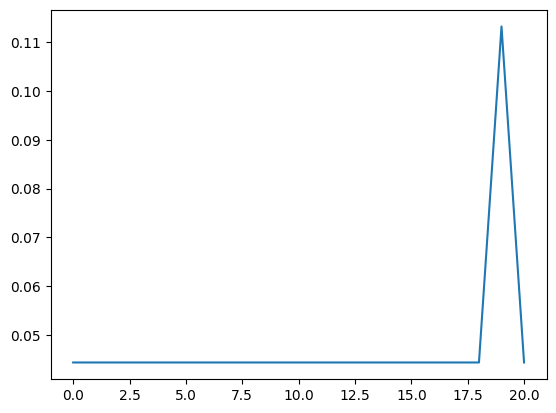

In [66]:
import matplotlib.pyplot as plt
plt.plot(y_pred[0][7].detach().numpy())

In [67]:
mlp_encoder = [128]

heads = 8
input_dim = 22
attention_input_dim = mlp_encoder[-1]
d_hidden = 128

output_mlp_decoder = [128,128,128,21]



encoder = torch.nn.ModuleList([MLP(input_dim, mlp_encoder),
           MultiHeadedAttention(heads, attention_input_dim, attention_input_dim, attention_input_dim, d_hidden, d_hidden), 
           MultiHeadedAttention(heads, heads*d_hidden, heads*d_hidden, heads*d_hidden, d_hidden, d_hidden)
          ])

decoder = torch.nn.ModuleList([MultiHeadedAttention(heads, d_hidden, d_hidden, heads*d_hidden, d_hidden, d_hidden),
           MultiHeadedAttention(heads, heads*d_hidden, d_hidden, heads*d_hidden, d_hidden, d_hidden),
           MLP(heads*d_hidden  + 1, output_mlp_decoder)
])



In [68]:
encoder[0]

MLP(
  (mlp): Sequential(
    (input_layer): Linear(in_features=22, out_features=128, bias=True)
    (relu): ReLU()
  )
)

In [69]:
decoder[-1]

MLP(
  (mlp): Sequential(
    (input_layer): Linear(in_features=1025, out_features=128, bias=True)
    (relu): ReLU()
    (hidden_layer_1): Linear(in_features=128, out_features=128, bias=True)
    (relu_2): ReLU()
    (hidden_layer_2): Linear(in_features=128, out_features=128, bias=True)
    (relu_3): ReLU()
    (hidden_layer_3): Linear(in_features=128, out_features=21, bias=True)
    (relu_4): ReLU()
  )
)

In [70]:
full_ANP = AttentiveNeuralProcess(encoder, decoder)

In [71]:
print(full_ANP)

AttentiveNeuralProcess(
  (encoder): ModuleList(
    (0): MLP(
      (mlp): Sequential(
        (input_layer): Linear(in_features=22, out_features=128, bias=True)
        (relu): ReLU()
      )
    )
    (1): MultiHeadedAttention(
      (attention): DotProductAttention()
      (W_q): Linear(in_features=128, out_features=1024, bias=True)
      (W_k): Linear(in_features=128, out_features=1024, bias=True)
      (W_v): Linear(in_features=128, out_features=1024, bias=True)
      (W_o): Linear(in_features=128, out_features=128, bias=True)
    )
    (2): MultiHeadedAttention(
      (attention): DotProductAttention()
      (W_q): Linear(in_features=1024, out_features=1024, bias=True)
      (W_k): Linear(in_features=1024, out_features=1024, bias=True)
      (W_v): Linear(in_features=1024, out_features=1024, bias=True)
      (W_o): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (decoder): ModuleList(
    (0): MultiHeadedAttention(
      (attention): DotProductAttention()
      

In [72]:
proteins = ProteinDataset(data=seqs)

In [73]:
def adjust_learning_rate(optimizer, step_num, warmup_step=4000):
    lr = 0.001 * warmup_step**0.5 * min(step_num * warmup_step**-1.5, step_num**-0.5)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [74]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

EPOCHS=2000
full_ANP.train()
optim = torch.optim.Adam(full_ANP.parameters(), lr = 1e-4)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    for i, batch in tqdm(enumerate(loader)):
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa)
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = full_ANP(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    print(loss)

246it [02:37,  1.56it/s]


tensor(2.9636, grad_fn=<MeanBackward0>)


246it [02:39,  1.54it/s]


tensor(2.9399, grad_fn=<MeanBackward0>)


246it [02:43,  1.51it/s]


tensor(2.8894, grad_fn=<MeanBackward0>)


246it [02:41,  1.53it/s]


tensor(2.8938, grad_fn=<MeanBackward0>)


246it [02:43,  1.50it/s]


tensor(2.8505, grad_fn=<MeanBackward0>)


246it [02:53,  1.42it/s]


tensor(2.8952, grad_fn=<MeanBackward0>)


246it [02:47,  1.46it/s]


tensor(2.7953, grad_fn=<MeanBackward0>)


246it [02:45,  1.49it/s]


tensor(2.7594, grad_fn=<MeanBackward0>)


246it [03:01,  1.36it/s]


tensor(2.7445, grad_fn=<MeanBackward0>)


246it [02:52,  1.42it/s]


tensor(2.7620, grad_fn=<MeanBackward0>)


246it [04:41,  1.14s/it]


tensor(2.7553, grad_fn=<MeanBackward0>)


246it [04:24,  1.08s/it]


tensor(2.7123, grad_fn=<MeanBackward0>)


246it [05:03,  1.24s/it]


tensor(2.7973, grad_fn=<MeanBackward0>)


246it [05:22,  1.31s/it]


tensor(2.7283, grad_fn=<MeanBackward0>)


246it [05:41,  1.39s/it]


tensor(2.6530, grad_fn=<MeanBackward0>)


246it [05:42,  1.39s/it]


tensor(2.7753, grad_fn=<MeanBackward0>)


246it [05:50,  1.42s/it]


tensor(2.7068, grad_fn=<MeanBackward0>)


246it [05:56,  1.45s/it]


tensor(2.7528, grad_fn=<MeanBackward0>)


246it [06:24,  1.56s/it]


tensor(2.7650, grad_fn=<MeanBackward0>)


246it [06:53,  1.68s/it]


tensor(2.7495, grad_fn=<MeanBackward0>)


246it [08:08,  1.98s/it]


tensor(2.6869, grad_fn=<MeanBackward0>)


246it [21:23,  5.22s/it] 


tensor(2.7786, grad_fn=<MeanBackward0>)


246it [08:56,  2.18s/it]


tensor(2.7299, grad_fn=<MeanBackward0>)


246it [07:44,  1.89s/it]


tensor(2.6618, grad_fn=<MeanBackward0>)


246it [4:34:24, 66.93s/it]  


tensor(2.6765, grad_fn=<MeanBackward0>)


246it [11:17,  2.75s/it]


tensor(3.0159, grad_fn=<MeanBackward0>)


246it [05:20,  1.30s/it]


tensor(2.9814, grad_fn=<MeanBackward0>)


246it [06:32,  1.60s/it]


tensor(2.9915, grad_fn=<MeanBackward0>)


246it [05:36,  1.37s/it]


tensor(2.9643, grad_fn=<MeanBackward0>)


246it [05:36,  1.37s/it]


tensor(2.9612, grad_fn=<MeanBackward0>)


246it [05:40,  1.39s/it]


tensor(2.9798, grad_fn=<MeanBackward0>)


246it [06:14,  1.52s/it]


tensor(2.9850, grad_fn=<MeanBackward0>)


246it [5:38:45, 82.62s/it]  


tensor(2.9353, grad_fn=<MeanBackward0>)


246it [7:07:13, 104.20s/it] 


tensor(2.9283, grad_fn=<MeanBackward0>)


246it [05:38,  1.38s/it]


tensor(2.9344, grad_fn=<MeanBackward0>)


246it [05:45,  1.40s/it]


tensor(2.9172, grad_fn=<MeanBackward0>)


246it [05:34,  1.36s/it]


tensor(2.9219, grad_fn=<MeanBackward0>)


246it [06:08,  1.50s/it]


tensor(2.9263, grad_fn=<MeanBackward0>)


246it [06:15,  1.53s/it]


tensor(2.8839, grad_fn=<MeanBackward0>)


246it [06:20,  1.54s/it]


tensor(2.9169, grad_fn=<MeanBackward0>)


246it [05:40,  1.39s/it]


tensor(2.9272, grad_fn=<MeanBackward0>)


246it [05:36,  1.37s/it]


tensor(2.9131, grad_fn=<MeanBackward0>)


246it [05:16,  1.29s/it]


tensor(2.9304, grad_fn=<MeanBackward0>)


246it [04:46,  1.16s/it]


tensor(2.9153, grad_fn=<MeanBackward0>)


246it [04:54,  1.20s/it]


tensor(2.9144, grad_fn=<MeanBackward0>)


246it [05:42,  1.39s/it]


tensor(2.9290, grad_fn=<MeanBackward0>)


246it [05:41,  1.39s/it]


tensor(2.9078, grad_fn=<MeanBackward0>)


246it [05:21,  1.31s/it]


tensor(2.9560, grad_fn=<MeanBackward0>)


246it [04:53,  1.19s/it]


tensor(2.8675, grad_fn=<MeanBackward0>)


246it [04:43,  1.15s/it]


tensor(2.9224, grad_fn=<MeanBackward0>)


246it [04:58,  1.21s/it]


tensor(2.8417, grad_fn=<MeanBackward0>)


246it [05:08,  1.25s/it]


tensor(2.8998, grad_fn=<MeanBackward0>)


246it [05:13,  1.27s/it]


tensor(2.8828, grad_fn=<MeanBackward0>)


246it [04:57,  1.21s/it]


tensor(2.8885, grad_fn=<MeanBackward0>)


246it [04:51,  1.18s/it]


tensor(2.9237, grad_fn=<MeanBackward0>)


246it [05:12,  1.27s/it]


tensor(2.8844, grad_fn=<MeanBackward0>)


246it [05:05,  1.24s/it]


tensor(2.8779, grad_fn=<MeanBackward0>)


246it [35:00,  8.54s/it]


tensor(2.9003, grad_fn=<MeanBackward0>)


246it [05:00,  1.22s/it]


tensor(2.8525, grad_fn=<MeanBackward0>)


246it [05:09,  1.26s/it]


tensor(2.9012, grad_fn=<MeanBackward0>)


246it [05:13,  1.27s/it]


tensor(2.8800, grad_fn=<MeanBackward0>)


246it [05:23,  1.31s/it]


tensor(2.8186, grad_fn=<MeanBackward0>)


246it [05:06,  1.25s/it]


tensor(2.8649, grad_fn=<MeanBackward0>)


246it [04:56,  1.21s/it]


tensor(2.8511, grad_fn=<MeanBackward0>)


246it [05:05,  1.24s/it]


tensor(2.8657, grad_fn=<MeanBackward0>)


246it [05:19,  1.30s/it]


tensor(2.8424, grad_fn=<MeanBackward0>)


246it [04:55,  1.20s/it]


tensor(2.8882, grad_fn=<MeanBackward0>)


246it [05:05,  1.24s/it]


tensor(2.9530, grad_fn=<MeanBackward0>)


246it [05:12,  1.27s/it]


tensor(2.8738, grad_fn=<MeanBackward0>)


246it [05:18,  1.29s/it]


tensor(2.9495, grad_fn=<MeanBackward0>)


246it [05:11,  1.27s/it]


tensor(2.8673, grad_fn=<MeanBackward0>)


246it [05:02,  1.23s/it]


tensor(2.8945, grad_fn=<MeanBackward0>)


246it [05:10,  1.26s/it]


tensor(2.9568, grad_fn=<MeanBackward0>)


246it [05:18,  1.29s/it]


tensor(2.9163, grad_fn=<MeanBackward0>)


246it [05:11,  1.26s/it]


tensor(2.8630, grad_fn=<MeanBackward0>)


246it [05:05,  1.24s/it]


tensor(2.8762, grad_fn=<MeanBackward0>)


246it [05:00,  1.22s/it]


tensor(2.8256, grad_fn=<MeanBackward0>)


246it [05:05,  1.24s/it]


tensor(2.8916, grad_fn=<MeanBackward0>)


246it [04:59,  1.22s/it]


tensor(2.8729, grad_fn=<MeanBackward0>)


246it [05:31,  1.35s/it]


tensor(2.8497, grad_fn=<MeanBackward0>)


246it [04:39,  1.13s/it]


tensor(2.8694, grad_fn=<MeanBackward0>)


246it [04:19,  1.05s/it]


tensor(2.8812, grad_fn=<MeanBackward0>)


246it [04:10,  1.02s/it]


tensor(2.8437, grad_fn=<MeanBackward0>)


246it [04:06,  1.00s/it]


tensor(2.8708, grad_fn=<MeanBackward0>)


11it [00:12,  1.11s/it]

KeyboardInterrupt



In [16]:
y_pred = full_ANP(x_context, y_context, x_target)

In [17]:
y_pred

tensor([[[0.0516, 0.0464, 0.0485,  ..., 0.0509, 0.0527, 0.0456],
         [0.0514, 0.0463, 0.0483,  ..., 0.0506, 0.0523, 0.0457],
         [0.0502, 0.0462, 0.0478,  ..., 0.0496, 0.0506, 0.0462],
         ...,
         [0.0517, 0.0464, 0.0485,  ..., 0.0509, 0.0528, 0.0455],
         [0.0500, 0.0462, 0.0478,  ..., 0.0495, 0.0505, 0.0462],
         [0.0514, 0.0463, 0.0483,  ..., 0.0506, 0.0522, 0.0457]],

        [[0.0513, 0.0462, 0.0482,  ..., 0.0505, 0.0520, 0.0458],
         [0.0498, 0.0464, 0.0478,  ..., 0.0493, 0.0496, 0.0464],
         [0.0512, 0.0462, 0.0482,  ..., 0.0505, 0.0520, 0.0458],
         ...,
         [0.0498, 0.0464, 0.0478,  ..., 0.0493, 0.0497, 0.0464],
         [0.0499, 0.0464, 0.0478,  ..., 0.0494, 0.0495, 0.0464],
         [0.0501, 0.0462, 0.0478,  ..., 0.0495, 0.0506, 0.0462]],

        [[0.0515, 0.0463, 0.0484,  ..., 0.0507, 0.0525, 0.0456],
         [0.0508, 0.0460, 0.0478,  ..., 0.0501, 0.0511, 0.0460],
         [0.0505, 0.0461, 0.0477,  ..., 0.0498, 0.0508, 0.

In [43]:
 - y_target * torch.log(y_pred + 1e-6)

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 2.9982, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 3.0071, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 2.9932],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 2.9896, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 3.0584, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

In [44]:
y_pred

tensor([[[0.0468, 0.0468, 0.0468,  ..., 0.0484, 0.0505, 0.0487],
         [0.0470, 0.0470, 0.0470,  ..., 0.0499, 0.0498, 0.0470],
         [0.0477, 0.0470, 0.0470,  ..., 0.0500, 0.0494, 0.0470],
         ...,
         [0.0468, 0.0468, 0.0468,  ..., 0.0488, 0.0504, 0.0481],
         [0.0465, 0.0465, 0.0465,  ..., 0.0474, 0.0507, 0.0501],
         [0.0467, 0.0467, 0.0467,  ..., 0.0482, 0.0505, 0.0490]],

        [[0.0470, 0.0470, 0.0470,  ..., 0.0498, 0.0500, 0.0470],
         [0.0466, 0.0466, 0.0466,  ..., 0.0477, 0.0506, 0.0497],
         [0.0469, 0.0469, 0.0469,  ..., 0.0492, 0.0503, 0.0476],
         ...,
         [0.0467, 0.0467, 0.0467,  ..., 0.0479, 0.0506, 0.0493],
         [0.0470, 0.0470, 0.0470,  ..., 0.0496, 0.0502, 0.0470],
         [0.0467, 0.0467, 0.0467,  ..., 0.0481, 0.0506, 0.0490]],

        [[0.0470, 0.0470, 0.0470,  ..., 0.0498, 0.0501, 0.0470],
         [0.0466, 0.0466, 0.0466,  ..., 0.0477, 0.0506, 0.0497],
         [0.0469, 0.0469, 0.0469,  ..., 0.0493, 0.0503, 0.

In [85]:
class LatentNeuralProcess(torch.nn.Module):
    """Basic Latent Neural Process. Takes a decoder and encoder of the form of MLPs, creates a latent variable, and then predicts. Current use case for proteins, but can and should be generalized to continuous data of time series type.
    input:
        determinstic_encoder: MLP
        latent_encoder: MLP
        latentLayer_mu: MLP
        latentLayer_log_var: MLP
        decoder: MLP

        for forward method:
            context_x, context_y, target_x, target_y (optional)

    output:
        y_pred: probabilistic predictions of amino acids of size (batch size, target points, number of amino acids)
        loss: cross entropy loss of probabilistic predictions. Only given if target_y is specified
    """
    def __init__(self,
                 deterministic_encoder,
                 latent_encoder,
                 latentLayer_mu,
                 latentLayer_log_var,
                 decoder,
                 **kwargs
    ):
        super().__init__(**kwargs)
        
        self.deterministic_encoder = deterministic_encoder

        self.latent_encoder = latent_encoder
        
        self.latentLayer_mu = latentLayer_mu
        self.latentLayer_log_var = latentLayer_log_var

        self.decoder = decoder

    def forward(self, context_x, context_y, target_x, target_y = None):
        full_context = torch.concat([context_x, context_y], dim=-1)

        deterministic_encoder_output = self.deterministic_encoder(full_context)
        deterministic_encoder_output = torch.mean(deterministic_encoder_output, dim=1)

        latent_encoder_output = self.latent_encoder(full_context)
        latent_encoder_output = torch.mean(latent_encoder_output, dim=1)

        z_mu = self.latentLayer_mu(latent_encoder_output)
        z_log_var = self.latentLayer_log_var(latent_encoder_output)

        z = torch.randn_like(z_log_var) * torch.exp(z_log_var/2) + z_mu

        z = z.unsqueeze(dim=1).tile((1, target_x.shape[1],1))

        r = deterministic_encoder_output.unsqueeze(dim=1).tile((1, target_x.shape[1],1))

        decoder_input = torch.concat([target_x, r, z], dim=-1)
        decoder_output = self.decoder(decoder_input)

        decoder_output = torch.nn.Softmax(dim=-1)(decoder_output)

        if target_y is not None:
            loss = self.cross_entropy_loss(decoder_output, target_y)
            
            X_full = torch.concat([context_x, target_x], dim=1)
            Y_full = torch.concat([context_y, target_y], dim=1)
            
            full_XY = torch.concat([X_full, Y_full], dim=-1)
            
            target_latent_encoder_output = self.latent_encoder(full_XY)
            target_latent_encoder_output = torch.mean(target_latent_encoder_output, dim=1)
            
            z_mu_target = self.latentLayer_mu(target_latent_encoder_output)
            z_log_var_target = self.latentLayer_log_var(target_latent_encoder_output)
            
            
            kl = self.kl_div_calc(z_mu, z_log_var, z_mu_target, z_log_var_target)
            return decoder_output, loss + torch.sum(kl)
        else:
            return decoder_output        
        
    def cross_entropy_loss(self, output, target_y):
        assert output.shape == target_y.shape

        cross_entropy_per_site_per_seq = -torch.sum(target_y * torch.log(output+1e-6), dim=-1)
        cross_entropy = torch.mean(cross_entropy_per_site_per_seq)
        
        return cross_entropy

    def kl_div_calc(self, z_mu_context, z_log_var_context, z_mu_target, z_log_var_target):
        q_context = torch.distributions.Normal(z_mu_context, torch.exp(z_log_var_context/2))
        q_target = torch.distributions.Normal(z_mu_target, torch.exp(z_log_var_target/2))
        
        kl = torch.distributions.kl.kl_divergence(q_context, q_target)
        return kl

In [86]:
latent_dim = 4
d_hidden = 128
x_dim = 1
y_dim = 21
deterministic_encoder = MLP(x_dim+y_dim, 4*[d_hidden])
latent_encoder = MLP(x_dim+y_dim, 4*[d_hidden])
latentLayer_mu = MLP(d_hidden, [d_hidden,d_hidden,latent_dim])
latentLayer_log_var = MLP(d_hidden, [d_hidden,d_hidden,latent_dim])
decoder = MLP(d_hidden+latent_dim+x_dim, [d_hidden, d_hidden, d_hidden, y_dim])

In [87]:
lnp = LatentNeuralProcess(deterministic_encoder,
                          latent_encoder,
                          latentLayer_mu,
                          latentLayer_log_var,
                          decoder)

In [ ]:
from tqdm import tqdm
from tensorboardX import SummaryWriter

EPOCHS=2000
full_ANP.train()
optim = torch.optim.Adam(lnp.parameters(), lr = 1e-4)
writer = SummaryWriter()

global_step = 0

min_context = int(0.1 * seqs.shape[1])
max_context = int(0.9 * seqs.shape[1])
len_aa = seqs.shape[1]


for epoch in range(EPOCHS):
    loader = torch.utils.data.DataLoader(proteins, batch_size=32, shuffle=True)
    for i, batch in tqdm(enumerate(loader)):
        
        global_step+=1
        (((x_context, y_context), x_target), y_target) = context_target_splitter(batch, min_context, max_context, len_aa)
        adjust_learning_rate(optim, global_step)
        
        y_pred, loss = lnp(x_context, y_context, x_target, y_target)

        optim.zero_grad()
        loss.backward()
        optim.step()

        writer.add_scalars('training_loss',{
                    'loss':loss,
                }, global_step)

    print(loss)

246it [00:10, 23.85it/s]


tensor(2.9938, grad_fn=<AddBackward0>)


246it [00:10, 24.35it/s]


tensor(2.9144, grad_fn=<AddBackward0>)


246it [00:10, 24.27it/s]


tensor(2.8974, grad_fn=<AddBackward0>)


246it [00:10, 23.47it/s]


tensor(2.8728, grad_fn=<AddBackward0>)


246it [00:10, 22.53it/s]


tensor(2.8001, grad_fn=<AddBackward0>)


246it [00:10, 22.47it/s]


tensor(2.8483, grad_fn=<AddBackward0>)


246it [00:11, 22.31it/s]


tensor(2.8326, grad_fn=<AddBackward0>)


246it [00:10, 22.96it/s]


tensor(2.8157, grad_fn=<AddBackward0>)


246it [00:10, 23.06it/s]


tensor(2.7702, grad_fn=<AddBackward0>)


246it [00:11, 22.29it/s]


tensor(2.7475, grad_fn=<AddBackward0>)


246it [00:10, 22.66it/s]


tensor(2.7939, grad_fn=<AddBackward0>)


246it [00:10, 23.21it/s]


tensor(2.6758, grad_fn=<AddBackward0>)


246it [00:10, 23.13it/s]


tensor(2.6661, grad_fn=<AddBackward0>)


246it [00:10, 22.93it/s]


tensor(2.7366, grad_fn=<AddBackward0>)


246it [00:10, 22.56it/s]


tensor(2.7926, grad_fn=<AddBackward0>)


246it [00:11, 21.83it/s]


tensor(2.6304, grad_fn=<AddBackward0>)


246it [00:10, 22.63it/s]


tensor(2.8282, grad_fn=<AddBackward0>)


246it [00:10, 23.00it/s]


tensor(2.6907, grad_fn=<AddBackward0>)


246it [00:10, 22.88it/s]


tensor(2.6922, grad_fn=<AddBackward0>)


246it [00:10, 22.58it/s]


tensor(2.7241, grad_fn=<AddBackward0>)


246it [00:11, 22.32it/s]


tensor(2.6806, grad_fn=<AddBackward0>)


246it [00:10, 22.50it/s]


tensor(2.6521, grad_fn=<AddBackward0>)


246it [00:10, 22.59it/s]


tensor(2.7170, grad_fn=<AddBackward0>)


246it [00:11, 22.17it/s]


tensor(2.6561, grad_fn=<AddBackward0>)


246it [00:13, 18.86it/s]


tensor(2.7170, grad_fn=<AddBackward0>)


246it [00:12, 19.68it/s]


tensor(2.6480, grad_fn=<AddBackward0>)


246it [00:11, 21.50it/s]


tensor(2.7134, grad_fn=<AddBackward0>)


246it [00:10, 24.12it/s]


tensor(2.6558, grad_fn=<AddBackward0>)


246it [00:09, 25.05it/s]


tensor(2.6626, grad_fn=<AddBackward0>)


246it [00:09, 25.16it/s]


tensor(2.6178, grad_fn=<AddBackward0>)


246it [00:10, 23.83it/s]


tensor(2.6325, grad_fn=<AddBackward0>)


246it [00:10, 22.89it/s]


tensor(2.6113, grad_fn=<AddBackward0>)


246it [00:10, 23.54it/s]


tensor(2.6305, grad_fn=<AddBackward0>)


246it [00:10, 22.49it/s]


tensor(2.6681, grad_fn=<AddBackward0>)


246it [00:10, 24.11it/s]


tensor(2.6868, grad_fn=<AddBackward0>)


246it [00:10, 24.22it/s]


tensor(2.6753, grad_fn=<AddBackward0>)


246it [00:10, 24.54it/s]


tensor(2.5920, grad_fn=<AddBackward0>)


246it [00:10, 22.47it/s]


tensor(2.5975, grad_fn=<AddBackward0>)


246it [00:10, 23.43it/s]


tensor(2.6177, grad_fn=<AddBackward0>)


246it [00:10, 22.77it/s]


tensor(2.6638, grad_fn=<AddBackward0>)


246it [00:10, 24.35it/s]


tensor(2.6347, grad_fn=<AddBackward0>)


246it [00:10, 24.55it/s]


tensor(2.5577, grad_fn=<AddBackward0>)


246it [00:10, 23.99it/s]


tensor(2.6659, grad_fn=<AddBackward0>)


246it [00:10, 23.22it/s]


tensor(2.5721, grad_fn=<AddBackward0>)


246it [00:10, 23.77it/s]


tensor(2.6899, grad_fn=<AddBackward0>)


246it [00:10, 23.57it/s]


tensor(2.5915, grad_fn=<AddBackward0>)


246it [00:10, 23.67it/s]


tensor(2.6738, grad_fn=<AddBackward0>)


246it [00:10, 24.21it/s]


tensor(2.6005, grad_fn=<AddBackward0>)


246it [00:10, 23.10it/s]


tensor(2.6551, grad_fn=<AddBackward0>)


246it [00:10, 22.73it/s]


tensor(2.6359, grad_fn=<AddBackward0>)


246it [00:10, 24.12it/s]


tensor(2.5967, grad_fn=<AddBackward0>)


246it [00:10, 24.27it/s]


tensor(2.6939, grad_fn=<AddBackward0>)


246it [00:10, 24.40it/s]


tensor(2.6713, grad_fn=<AddBackward0>)


246it [00:10, 22.48it/s]


tensor(2.5757, grad_fn=<AddBackward0>)


246it [00:12, 19.45it/s]


tensor(2.5810, grad_fn=<AddBackward0>)


246it [00:11, 21.68it/s]


tensor(2.6221, grad_fn=<AddBackward0>)


246it [00:11, 20.81it/s]


tensor(2.5903, grad_fn=<AddBackward0>)


246it [00:11, 21.06it/s]


tensor(2.6396, grad_fn=<AddBackward0>)


246it [00:10, 22.89it/s]


tensor(2.5997, grad_fn=<AddBackward0>)


246it [00:10, 22.78it/s]


tensor(2.6436, grad_fn=<AddBackward0>)


246it [00:10, 22.40it/s]


tensor(2.6079, grad_fn=<AddBackward0>)


246it [00:10, 24.06it/s]


tensor(2.6504, grad_fn=<AddBackward0>)


246it [00:10, 24.35it/s]


tensor(2.5931, grad_fn=<AddBackward0>)


246it [00:10, 24.50it/s]


tensor(2.5845, grad_fn=<AddBackward0>)


246it [00:10, 24.11it/s]


tensor(2.6385, grad_fn=<AddBackward0>)


246it [00:10, 22.65it/s]


tensor(2.6610, grad_fn=<AddBackward0>)


246it [00:10, 23.45it/s]


tensor(2.6588, grad_fn=<AddBackward0>)


246it [00:10, 23.62it/s]


tensor(2.5210, grad_fn=<AddBackward0>)


246it [00:10, 23.84it/s]


tensor(2.5937, grad_fn=<AddBackward0>)


246it [00:10, 23.44it/s]


tensor(2.6780, grad_fn=<AddBackward0>)


246it [00:10, 22.98it/s]


tensor(2.6656, grad_fn=<AddBackward0>)


246it [00:11, 21.85it/s]


tensor(2.6179, grad_fn=<AddBackward0>)


246it [00:10, 22.93it/s]


tensor(2.5776, grad_fn=<AddBackward0>)


246it [00:10, 22.96it/s]


tensor(2.6006, grad_fn=<AddBackward0>)


246it [00:10, 23.27it/s]


tensor(2.6226, grad_fn=<AddBackward0>)


246it [00:10, 22.98it/s]


tensor(2.6715, grad_fn=<AddBackward0>)


246it [00:10, 22.47it/s]


tensor(2.5967, grad_fn=<AddBackward0>)


246it [00:10, 22.80it/s]


tensor(2.5405, grad_fn=<AddBackward0>)


189it [00:08, 24.12it/s]